# Application with new data

This tutorial demonstrates how to pseudo-spatiotemporal analysis on BaristaSeq mouse visual cortex data using Pysodb and SpaceFlow.

A reference paper can be found at https://www.nature.com/articles/s41467-022-31739-w.

This tutorial refers to the following tutorial at https://github.com/hongleir/SpaceFlow/blob/master/tutorials/seqfish_mouse_embryogenesis.ipynb. At the same time, the way of loadding data is modified by using Pysodb.

## Import packages and set configurations

In [1]:
# Use the Python warnings module to filter and ignore any warnings that may occur in the program after this point.
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import several python packages commonly used in data analysis and visualization.
# numpy (imported as np) is a package for numerical computing with arrays.
import numpy as np
# scanpy (imported as sc) is a package for single-cell RNA sequencing analysis.
import scanpy as sc
# matplotlib.pyplot (imported as plt) is a package for data visualization.
import matplotlib.pyplot as plt
# seaborn (imported as sns) is a package for statistical data visualization, providing high-level interfaces for creating informative and attractive visualizations.
import seaborn as sns

In [3]:
# from SpaceFlow package import SpaceFlow module
from SpaceFlow import SpaceFlow

In [4]:
# Imports a palettable package
import palettable
# Create three variables with lists of colors for categorical visualizations and biotechnology-related visualizations, respectively.
cmp_pspace = palettable.cartocolors.diverging.TealRose_7.mpl_colormap
cmp_domain = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
cmp_ct = palettable.cartocolors.qualitative.Safe_10.mpl_colors

When encountering the error "No module name 'palettable'", users need to activate conda's virtual environment first at the terminal and run the following command in the terminal: "pip install palettable". This approach can be applied to other packages as well, by replacing 'palettable' with the name of the desired package.

## Streamline development of loading spatial data with Pysodb

In [5]:
# Import pysodb package
# Pysodb is a Python package that provides a set of tools for working with SODB databases. 
# SODB is a format used to store data in memory-mapped files for efficient access and querying. 
# This package allows users to interact with SODB files using Python.
import pysodb

In [6]:
# Initialize the sodb object
sodb = pysodb.SODB()

In [7]:
# Define names of the dataset_name and experiment_name
dataset_name = 'Sun2021Integrating'
experiment_name = 'Slice_1'
# Load a specific experiment
# It takes two arguments: the name of the dataset and the name of the experiment to load.
# Two arguments are available at https://gene.ai.tencent.com/SpatialOmics/.
#%%time
adata = sodb.load_experiment(dataset_name,experiment_name)

load experiment[Slice_1] in dataset[Sun2021Integrating]


In [8]:
# Remove cells belong to the layers 'outside_VISp' and 'VISp'
adata = adata[adata.obs['layer']!='outside_VISp']
adata = adata[adata.obs['layer']!='VISp']

In [9]:
# Filter out genes
sc.pp.filter_genes(adata, min_cells=3)

## Perform SpaceFlow for pseudo-spatiotemporal analysis

In [10]:
# Create SpaceFlow Object
#%%time
#sf = SpaceFlow.SpaceFlow(adata=adata)    
sf = SpaceFlow.SpaceFlow(
    count_matrix=adata.X, 
    spatial_locs=adata.obsm['spatial'], 
    sample_names=adata.obs_names, 
    gene_names=adata.var_names
)

When encountering the error "Error: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().", in the "SpaceFlow.py" file from the SpaceFlow package, the user is advised to make the following modifications within the init function. Replace "elif count_matrix and spatial_locs:" with "elif count_matrix is not None and spatial_locs is not None:". Additionally, modify "if gene_names:" and "if sample_names:" to "if gene_names is not None:" and "if sample_names is not None:" respectively. The above modifications ensure that the if statement returns a single boolean value. respectively.

In [11]:
# Preprocess data
#%%time
sf.preprocessing_data(n_top_genes=3000)

When encountering the error "Error: You can drop duplicate edges by setting the 'duplicates' kwarg",in "SpaceFlow.py" from the SpaceFlow package, modify the preprocessing_data function by: (1) removing target_sum=1e4 from sc.pp.normalize_total(); (2) changing the flavor argument to 'seurat' in sc.pp.highly_variable_genes(); (3) Save and rerun the analysis.

When encountering the error "Error: module 'networkx' has no attribute 'to_scipy_sparse_matrix'", users should first activate the virtual environment at the terminal and then downgrade NetworkX with the following command："pip install networkx==2.8". This will ensure that the correct version of NetworkX is installed within the specified virtual environment.

In [12]:
# Train a deep graph network model
#%%time
sf.train(
    spatial_regularization_strength=0.1, 
    z_dim=50, 
    lr=1e-3, 
    epochs=1000, 
    max_patience=50, 
    min_stop=100, 
    random_seed=42, 
    gpu=0, 
    regularization_acceleration=True, 
    edge_subset_sz=1000000
)

Epoch 2/1000, Loss: 1.4427732229232788
Epoch 12/1000, Loss: 1.404854416847229
Epoch 22/1000, Loss: 1.355185866355896
Epoch 32/1000, Loss: 1.278242826461792
Epoch 42/1000, Loss: 1.1435610055923462
Epoch 52/1000, Loss: 0.9432040452957153
Epoch 62/1000, Loss: 0.714905321598053
Epoch 72/1000, Loss: 0.5822354555130005
Epoch 82/1000, Loss: 0.5121979713439941
Epoch 92/1000, Loss: 0.425785630941391
Epoch 102/1000, Loss: 0.37741926312446594
Epoch 112/1000, Loss: 0.3343759775161743
Epoch 122/1000, Loss: 0.3119865655899048
Epoch 132/1000, Loss: 0.26779788732528687
Epoch 142/1000, Loss: 0.22297403216362
Epoch 152/1000, Loss: 0.28504329919815063
Epoch 162/1000, Loss: 0.22740697860717773
Epoch 172/1000, Loss: 0.234877809882164
Epoch 182/1000, Loss: 0.1949552297592163
Epoch 192/1000, Loss: 0.20016708970069885
Epoch 202/1000, Loss: 0.2028239667415619
Epoch 212/1000, Loss: 0.173057422041893
Epoch 222/1000, Loss: 0.21973812580108643
Epoch 232/1000, Loss: 0.17184185981750488
Epoch 242/1000, Loss: 0.20747

array([[ 0.8899192 ,  0.01435345,  0.7866027 , ...,  0.5507234 ,
        -0.03758647, -0.08572218],
       [ 0.8003285 ,  0.00401396,  0.72124624, ...,  0.42994535,
        -0.04228881, -0.06209074],
       [ 0.8963664 ,  0.01202957,  0.7585074 , ...,  0.59778905,
        -0.03772109, -0.08880965],
       ...,
       [ 0.48202616,  0.01098088,  0.6471445 , ..., -0.00690297,
         0.73529345,  0.32098433],
       [ 0.5201945 ,  0.00505677,  0.6052369 , ..., -0.00182656,
         0.46181548,  0.19144082],
       [ 0.4544619 ,  0.00249925,  0.5253095 , ..., -0.00313081,
         0.6240246 ,  0.4014499 ]], dtype=float32)

In [13]:
# Idenfify the spatiotemporal patterns through pseudo-Spatiotemporal Map (pSM)
sf.pseudo_Spatiotemporal_Map(pSM_values_save_filepath="./pSM_values.tsv", n_neighbors=20, resolution=1.0)


Performing pseudo-Spatiotemporal Map
pseudo-Spatiotemporal Map(pSM) calculation complete, pSM values of cells or spots saved at ./pSM_values.tsv!


In [14]:
# Create a new column called 'pspace' from pSM values
adata.obs['pspace'] = np.array(sf.pSM_values)

In [15]:
# Create a UMAP projection from SpaceFlow's embedding 
adata.obsm['embedding'] = sf.embedding
sc.pp.neighbors(adata, n_neighbors=20, use_rep='embedding')
sc.tl.umap(adata)

In [16]:
# Since this dataset contains 'depth_um' in obs, a iroot was set to be the cell with smallest depth_um. 
# For datasets without depth information, one can use the pseudo_Spatiotemporal_Map function
# Here set the iroot according to "depth_um"

# Select the root cell for trajectory inference based on its depth, by setting the index of the cell with the smallest 'depth_um' value as the root
adata.uns['iroot'] = np.argmin(adata.obs['depth_um'])
sc.tl.diffmap(adata)
sc.tl.dpt(adata)  

<Axes: title={'center': 'dpt_pseudotime'}, xlabel='X_umap1', ylabel='X_umap2'>

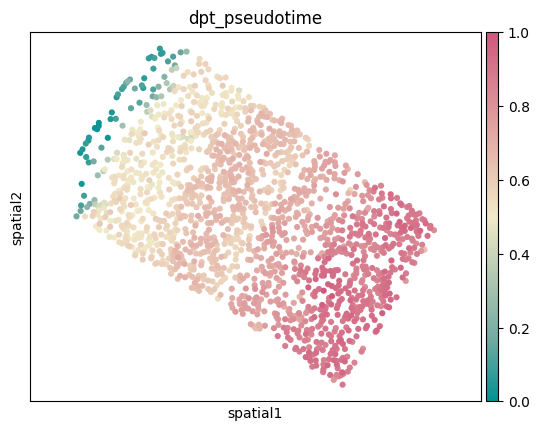

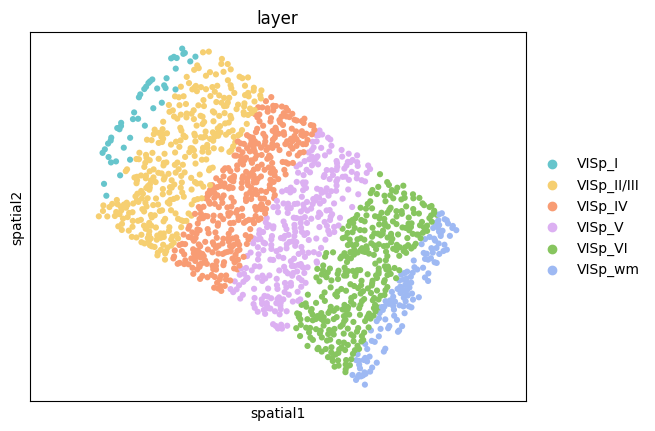

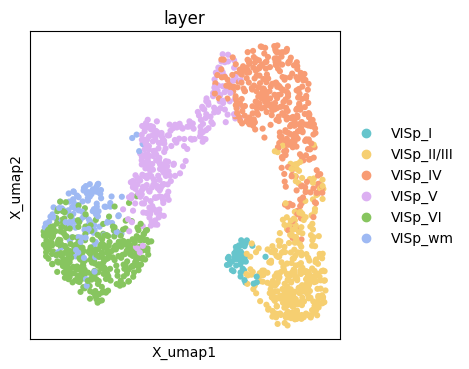

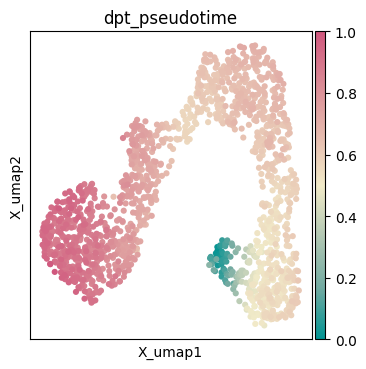

In [17]:
# Plot spatial embedding and UMAP embedding for diffusion pseudotime and layer(label), respectively

# si = 'Slice_1'

ax = sc.pl.embedding(adata,basis='spatial',color=['dpt_pseudotime'],show=False,color_map=cmp_pspace)
ax.axis('equal')
# plt.savefig(f'../figures/pspace/BaristaSeq_{si}_pspace.png',bbox_inches='tight',transparent=True,dpi=400)
# plt.savefig(f'../figures/pspace/BaristaSeq_{si}_pspace.pdf',bbox_inches='tight',transparent=True,dpi=400)

ax = sc.pl.embedding(adata,basis='spatial',color='layer',show=False,palette=cmp_domain)
ax.axis('equal')
# plt.savefig(f'../figures/pspace/BaristaSeq_{si}_domain.png',bbox_inches='tight',transparent=True,dpi=400)
# plt.savefig(f'../figures/pspace/BaristaSeq_{si}_domain.pdf',bbox_inches='tight',transparent=True,dpi=400)

fig, ax = plt.subplots()
fig.set_size_inches(4, 4)
sc.pl.embedding(adata,basis='X_umap',color='layer',show=False,palette=cmp_domain,ax=ax)
#ax.axis('equal')
# plt.savefig(f'../figures/pspace/BaristaSeq_{si}_UMAP_domain.png',bbox_inches='tight',transparent=True,dpi=400)
# plt.savefig(f'../figures/pspace/BaristaSeq_{si}_UMAP_domain.pdf',bbox_inches='tight',transparent=True,dpi=400)

fig, ax = plt.subplots()
fig.set_size_inches(4, 4)
sc.pl.embedding(adata,basis='X_umap',color=['dpt_pseudotime'],show=False,color_map=cmp_pspace,ax=ax)
#ax.axis('equal')
# plt.savefig(f'../figures/pspace/BaristaSeq_{si}_UMAP_pspace.png',bbox_inches='tight',transparent=True,dpi=400)
# plt.savefig(f'../figures/pspace/BaristaSeq_{si}_UMAP_pspace.pdf',bbox_inches='tight',transparent=True,dpi=400)

<Axes: xlabel='layer', ylabel='dpt_pseudotime'>

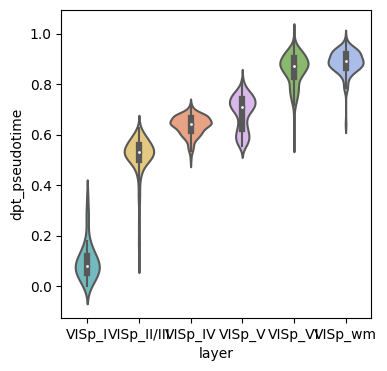

In [18]:
# Check whether the pseudo-spatiotemporal (dpt_pseudotime) value from infer increases according to the layer of the cortex
adata_use = adata
fig,ax = plt.subplots(figsize=(4,4))
sns.violinplot(data=adata_use.obs,x='layer',y='dpt_pseudotime',palette = adata_use.uns['layer_colors'],ax=ax)
# plt.savefig(f'../figures/pspace/BaristaSeq_{si}_violin.png',bbox_inches='tight',transparent=True,dpi=400)
# plt.savefig(f'../figures/pspace/BaristaSeq_{si}_violin.pdf',bbox_inches='tight',transparent=True,dpi=400)

In [19]:
adata.obs

Slice         x        y  Dist to pia  Dist to bottom    Angle  \
20022       1  12186.20  8617.70     1029.630         205.270  174.894   
20023       1  12789.10  8690.82     1072.540         168.011  172.700   
20024       1  11927.80  8715.20     1003.280         231.018  177.522   
20025       1  12860.60  8729.82     1075.760         165.770  172.700   
20027       1  12587.60  8760.70     1052.380         187.131  172.700   
...       ...       ...      ...          ...             ...      ...   
230184      1   3239.60  8952.13      307.763         971.248  178.930   
230186      1   2713.10  9006.56      261.052        1018.700  177.579   
230187      1   2193.10  9009.00      214.572        1063.490  172.257   
230188      1   2405.97  9015.50      234.015        1045.450  171.641   
230192      1   2963.35  9161.75      273.140        1005.830  178.946   

        unused-1  unused-2      x_um     y_um     depth_um        layer  \
20022          0         0  1218.620  861.770  1093.752193      VISp_VI   
20023          0         0  1278.910  869.082  1139.629730      VISp_VI   
20024          0         0  1192.780  871.520  1066.880345      VISp_VI   
20025          0         0  1286.060  872.982  1143.373530      VISp_VI   
20027          0         0  1258.760  876.070  1119.019231      VISp_VI   
...          ...       ...       ...      ...          ...          ...   
230184         0         0   323.960  895.213   333.538252  VISp_II/III   
230186         0         0   271.310  900.656   286.855966  VISp_II/III   
230187         0         0   219.310  900.900   243.621417  VISp_II/III   
230188         0         0   240.597  901.550   260.900559  VISp_II/III   
230192         0         0   296.335  916.175   298.913498  VISp_II/III   

       leiden    pspace  dpt_pseudotime  
20022       1  0.911279        0.903298  
20023       4  0.892462        0.882942  
20024       1  0.928142        0.921913  
20025       4  0.895546        0.886348  
20027       3  0.909229        0.901504  
...       ...       ...             ...  
230184      4  0.715771        0.520664  
230186      2  0.703140        0.509154  
230187      0  0.783840        0.606285  
230188      0  0.727675        0.530846  
230192      0  0.720848        0.534821  

[1525 rows x 15 columns]

In [20]:
adata_use.uns['layer_colors']

['#66c5cc', '#f6cf71', '#f89c74', '#dcb0f2', '#87c55f', '#9eb9f3']

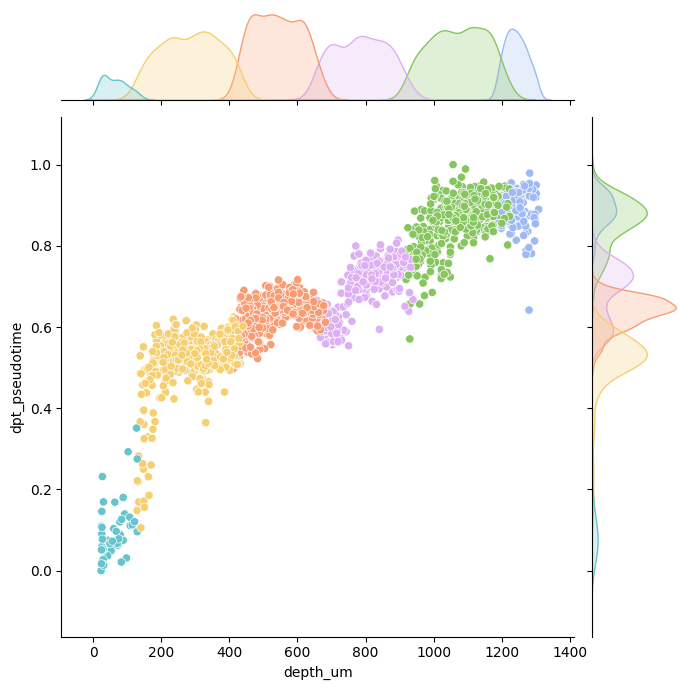

In [21]:
# Check whether the pseudo-spatiotemporal (dpt_pseudotime) from infer was correlated with their depth_um (depth_um)
adata_use = adata
g = sns.jointplot(x="depth_um", y="dpt_pseudotime", data=adata_use.obs,hue='layer',
                  palette=list(adata_use.uns['layer_colors']),
                  # kind="reg", 
                  # truncate=False,
                  # xlim=(0, 60), ylim=(0, 12),
                  # color="m", 
                  height=7)
g.ax_joint.legend_.remove()
# plt.savefig(f'../figures/pspace/BaristaSeq_{si}_jointplot.png',bbox_inches='tight',transparent=True,dpi=400)
# plt.savefig(f'../figures/pspace/BaristaSeq_{si}_jointplot.pdf',bbox_inches='tight',transparent=True,dpi=400)